In [13]:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, sqrt, pi
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

from mpl_toolkits import mplot3d

In [14]:
epochs = 10
device = torch.device("cpu")

eps = 1

learning_rate = 1e-3
batchflag = True
batchsize = 128

start = 0.
end = 1.
x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

p = 1 - np.exp(-1/eps)
q = 1 + np.exp(-1/eps)
d = 1/(q - 2*eps*p)

actual_soln = (np.sin(np.pi*x) + (eps*np.pi/p)*(np.exp(-x/eps) + np.exp((x-1)/eps) - q) ) * (2*y*(1 - y**2) + eps * ( p*d*(1-2*y) - 3*q/p + (3/p - d)*np.exp(-y/eps) + (3/p + d)*np.exp((y-1)/eps)))

In [15]:

def train(device,x,y,eps,learning_rate,epochs,batch_flag,batch_size,actual_soln):

	if(batch_flag):
		xnet = torch.Tensor(x)
		ynet = torch.Tensor(y) 

		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
		print(len(dataloader))
	else:
		xnet = torch.Tensor(x)
		ynet = torch.Tensor(y) 



	h_n = 128
	input_n = 2  
	class Swish(nn.Module):
		def __init__(self, inplace=True):
			super(Swish, self).__init__()
			self.inplace = inplace

		def forward(self, x):
			if self.inplace:
				x.mul_(torch.sigmoid(x))
				return x
			else:
				return x * torch.sigmoid(x)
	

	class Net(nn.Module):
		def __init__(self):
			super(Net, self).__init__()
			self.tanh = nn.Tanh()
			self.lin0 = nn.Linear(input_n,h_n)
			self.lin = nn.Linear(h_n,h_n)
			self.lin1 = nn.Linear(h_n,1)
			self.swish = Swish()
		def forward(self,x):		
			tanh1 = self.tanh(x)
			tanh2 = self.tanh(1 - x)
			tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
			tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
			x = self.lin0(x)
			x = self.swish(x)
			x = self.lin(x)
			x = self.swish(x)
			x = self.lin(x)
			x = self.swish(x)
			x = self.lin1(x)
			out = x*tanh11*tanh22
			return  out

	
	net = Net()#.to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)
		U = U.view(len(U),-1)
		
		p = 1 - np.exp(-1/eps);q = 1 + np.exp(-1/eps);d = 1/(q - 2*eps*p)
		
		soln = (torch.sin(np.pi*xnet) + (eps*np.pi/p)*(torch.exp(-xnet/eps) + torch.exp((xnet-1)/eps) - q) ) * (2*ynet*(1 - ynet*ynet) + eps * ( p*d*(1-2*ynet) - 3*q/p + (3/p - d)*torch.exp(-ynet/eps) + (3/p + d)*torch.exp((ynet-1)/eps)))
		
		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)
		
		
		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	def plot_net():
		points = torch.cat((xnet,ynet),1)
		U = net(points)
		z = U.detach().numpy()
		
		x = np.linspace(0.,1.,100);y = np.linspace(0.,1.,100)
		x,y = np.meshgrid(x,y)
		fig = plt.figure()
		ax = plt.axes(projection='3d')
		ax.plot_surface(x,y,z.reshape(100,100))
		plt.show()

	losses = []
	tic = time.time()

	xx = np.linspace(0.,1.,100);yy = np.linspace(0.,1.,100)
	xx,yy = np.meshgrid(xx,yy)

	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 30:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss = Loss_criterion(x_in,y_in)
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('Train Epoch: {} \tLoss: {:.10f}'.format(epoch, loss.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				ax = plt.axes(projection='3d')
				ax.plot_surface(xx,yy,z.reshape(100,100))
				plt.show()
			
			losses.append([loss.item(),actual_loss])

	else:
		for epoch in range(epochs):
			if epoch == 50:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
		
			net.zero_grad()
			loss = Loss_criterion(xnet,ynet)
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 5 == 0:
				ax = plt.axes(projection='3d')
				ax.plot_surface(xx,yy,z.reshape(100,100))
				plt.show()
			
			losses.append([loss.item(),actual_loss])

	toc = time.time()
	elapseTime = toc - tic
	print ("Time elapsed = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output 

78
Train Epoch: 0 	Loss: 8.0987491608
Train Epoch: 0 	Loss: 0.5873253942
Train Epoch: 0 	Loss: 0.1013224870
Train Epoch: 0 	Loss: 0.0504607782

After Epoch 0, 	 Actual solution loss: 0.0000000001



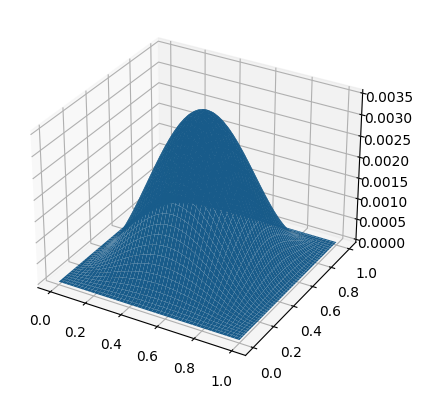

Train Epoch: 1 	Loss: 0.0262098368
Train Epoch: 1 	Loss: 0.0197117329
Train Epoch: 1 	Loss: 0.0093889758
Train Epoch: 1 	Loss: 0.0076825200

After Epoch 1, 	 Actual solution loss: 0.0000000000



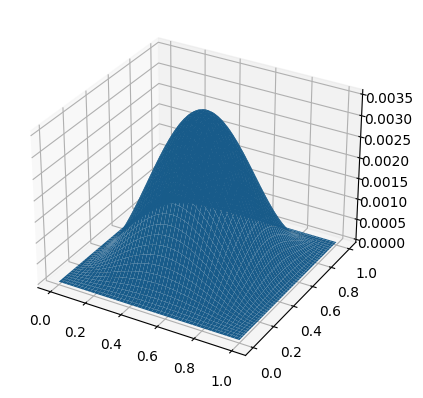

Train Epoch: 2 	Loss: 0.0080090584
Train Epoch: 2 	Loss: 0.0047362782
Train Epoch: 2 	Loss: 0.0042723343
Train Epoch: 2 	Loss: 0.0053944117

After Epoch 2, 	 Actual solution loss: 0.0000000000



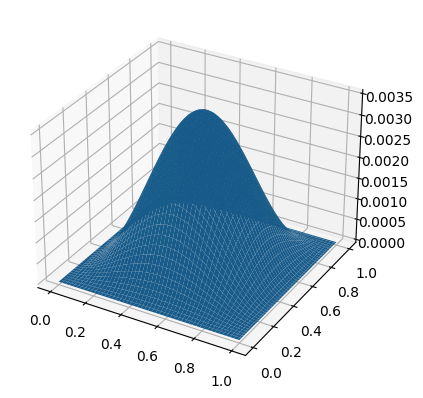

Train Epoch: 3 	Loss: 0.0052661290
Train Epoch: 3 	Loss: 0.0025498965
Train Epoch: 3 	Loss: 0.0022948908
Train Epoch: 3 	Loss: 0.0024993767

After Epoch 3, 	 Actual solution loss: 0.0000000000



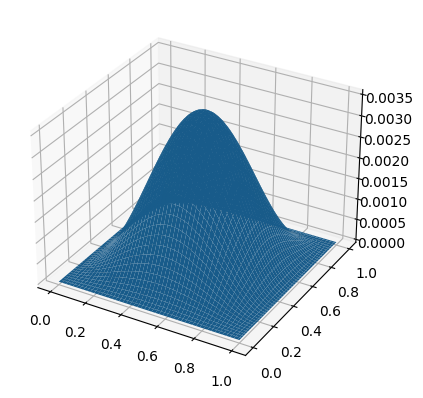

Train Epoch: 4 	Loss: 0.0015591886
Train Epoch: 4 	Loss: 0.0012279535
Train Epoch: 4 	Loss: 0.0018599269
Train Epoch: 4 	Loss: 0.0010678875

After Epoch 4, 	 Actual solution loss: 0.0000000000



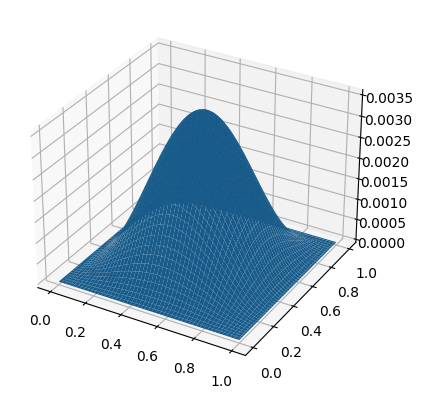

Train Epoch: 5 	Loss: 0.0011298738
Train Epoch: 5 	Loss: 0.0011263739
Train Epoch: 5 	Loss: 0.0010653598
Train Epoch: 5 	Loss: 0.0007144891

After Epoch 5, 	 Actual solution loss: 0.0000000000



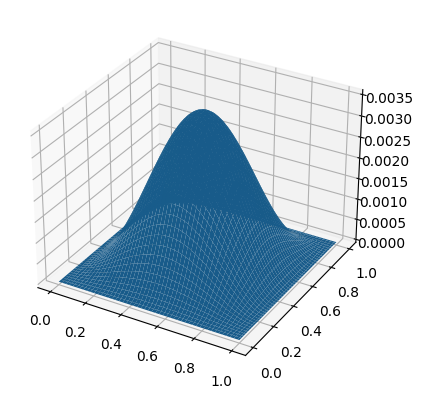

Train Epoch: 6 	Loss: 0.0007408267
Train Epoch: 6 	Loss: 0.0005536897
Train Epoch: 6 	Loss: 0.0010256646
Train Epoch: 6 	Loss: 0.0007778029

After Epoch 6, 	 Actual solution loss: 0.0000000000



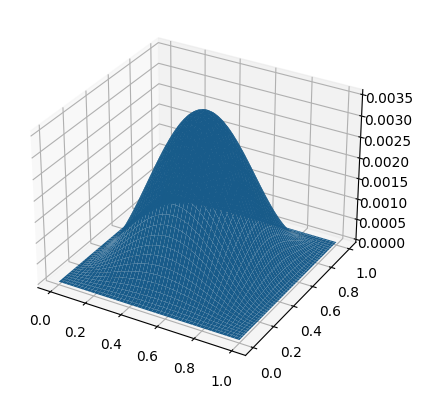

Train Epoch: 7 	Loss: 0.0011695214
Train Epoch: 7 	Loss: 0.0010865944
Train Epoch: 7 	Loss: 0.0005596498
Train Epoch: 7 	Loss: 0.0003739845

After Epoch 7, 	 Actual solution loss: 0.0000000000



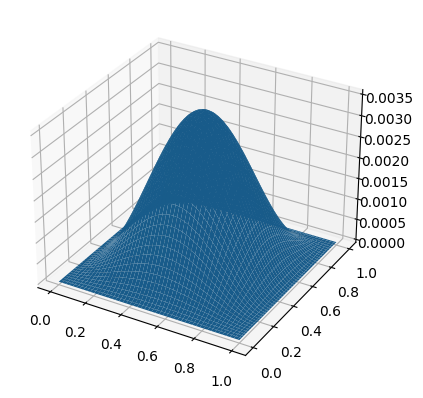

Train Epoch: 8 	Loss: 0.0003322786
Train Epoch: 8 	Loss: 0.0003309455
Train Epoch: 8 	Loss: 0.0003276545
Train Epoch: 8 	Loss: 0.0006640191

After Epoch 8, 	 Actual solution loss: 0.0000000000



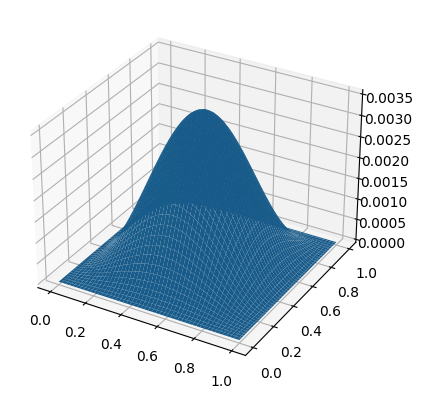

Train Epoch: 9 	Loss: 0.0002380034
Train Epoch: 9 	Loss: 0.0006191480
Train Epoch: 9 	Loss: 0.0002190806
Train Epoch: 9 	Loss: 0.0002445774

After Epoch 9, 	 Actual solution loss: 0.0000000001



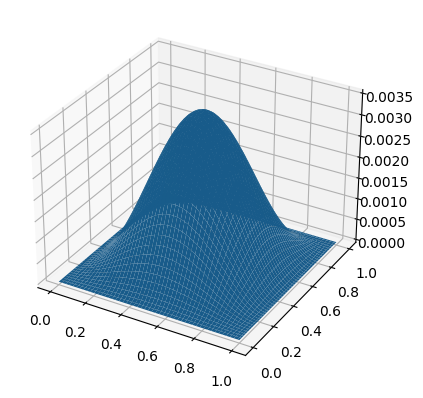

Time elapsed =  411.76200222969055


In [16]:
output = train(device,x,y,eps,learning_rate,epochs,batchflag,batchsize,actual_soln)

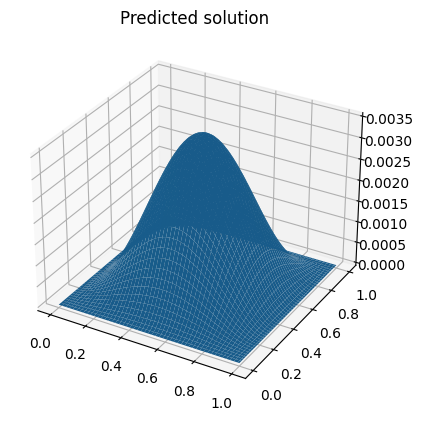

In [19]:
z = output.detach().numpy()
x = np.linspace(0.,1.,100);y = np.linspace(0.,1.,100)
x,y = np.meshgrid(x,y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x,y,z.reshape(100,100))
plt.title('Predicted solution')
plt.show()

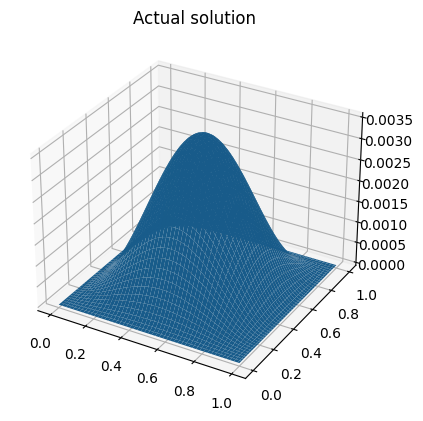

In [21]:
x = np.linspace(0.,1.,100);y = np.linspace(0.,1.,100)
x,y = np.meshgrid(x,y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(x,y,actual_soln.reshape(100,100))
plt.title('Actual solution')
plt.show()